In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile as wav
import numpy as np
from numpy.lib import stride_tricks
import torch
import torchvision
import cv2
import librosa
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import transforms
import numpy as np
from collections import Counter
import torch.nn as nn
import glob

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
destination_path = 'C:/Users/Afreen khan/OneDrive/Desktop/dataset'
for split in ['train', 'test']:
    for folder in folder_names:
        os.makedirs(os.path.join(destination_path, split, folder), exist_ok=True)
def load_images_from_folders(source_path, folder_names):
    image_paths = []
    labels = []
    for label, folder_name in enumerate(folder_names):
        folder_path = os.path.join(source_path, folder_name)
        for filename in os.listdir(folder_path):
            if filename.endswith('.png') or filename.endswith('.jpg'):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)
    return image_paths, labels
image_paths, labels = load_images_from_folders(source_path, folder_names)
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, train_size=0.8, stratify=labels)
def copy_files(file_list, labels_list, split):
    for file, label in zip(file_list, labels_list):
        class_name = folder_names[label]
        dest_folder = os.path.join(destination_path, split, class_name)
        shutil.copy(file, dest_folder)
copy_files(X_train, Y_train, 'train')
copy_files(X_test, Y_test, 'test')
print("Data has been successfully organized into train and test folders.")

Data has been successfully organized into train and test folders.


In [4]:
def read_audio(conf, pathname, trim_long_data):
    try:
        y, sr = librosa.load(pathname, sr=conf.sampling_rate)
        # trim silence
        if len(y) > 0:  # check if the audio is non-empty
            y, _ = librosa.effects.trim(y)  # trim silence by default top_db=60
        # handle long or short audio
        if len(y) > conf.samples:  # audio is too long
            if trim_long_data:
                y = y[:conf.samples]  # trim to the desired length
            else:
                # pad audio to conf.samples length
                padding = conf.samples - len(y)
                offset = padding // 2
                y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
        return y, sr  # return the processed audio and sampling rate
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None, None  # return None if there's an error

In [5]:
def audio_to_melspectrogram(conf, audio):
    # Calculate the Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(
        audio,
        sr=conf.sampling_rate,
        n_mels=conf.n_mels,
        hop_length=conf.hop_length,
        n_fft=conf.n_fft,
        fmin=conf.fmin,
        fmax=conf.fmax
    )
    # Convert the spectrogram to decibels (log scale)
    spectrogram = librosa.power_to_db(spectrogram)
    # Ensure the spectrogram is of type float32
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [6]:
class Conf:
    # Preprocessing settings
    sampling_rate = 16000
    duration = 7
    hop_length = 100 * duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

In [7]:
def rename_file(img_name):
    img_name = img_name.split("/")[-1]  # Get the file name from the full path
    img_name = img_name[:-4]  # Remove the file extension
    img_name += ".jpg"  # Add the new extension
    return img_name  # Return the modified file name

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
def save_image_from_sound(audio_path, save_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=None)
    # Generate a mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    # Plot and save the mel spectrogram as an image
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    # Save the image
    image_filename = os.path.join(save_path, os.path.basename(audio_path).replace('.wav', '.png'))
    plt.savefig(image_filename)
    plt.close()

In [9]:
def save_image_from_sound(audio_path, save_path):
    try:
        print(f"Loading audio: {audio_path}")  # Debug: Print audio path
        y, sr = librosa.load(audio_path, sr=None)
        if y is None or len(y) == 0:
            print(f"Audio data is empty for: {audio_path}")  # Debug: Check for empty audio
            return
        # Generate a mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Plot and save the mel spectrogram as an image
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        plt.tight_layout()
        # Save the image
        image_filename = os.path.join(save_path, os.path.basename(audio_path).replace('.wav', '.png'))
        plt.savefig(image_filename)
        plt.close()
        print(f"Saved image: {image_filename}")
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
# List of folder names where images will be saved (this will be mirrored from the source)
# The names should match exactly with the source folder names
source_folders = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
# Path to the main folder that contains all the subfolders with audio files
source_path = 'C:/Users/Afreen khan/Downloads/donateacry_corpus'
# Path to the 'Images Folder' on your desktop
destination_base_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
# Iterate over each folder in the source directory
for source_folder in source_folders:
    source_folder_path = os.path.join(source_path, source_folder)
    if os.path.isdir(source_folder_path):  # Check if it is a subfolder in the source
        # Create corresponding destination folder (if it doesn't exist)
        destination_folder_path = os.path.join(destination_base_path, source_folder)
        if not os.path.exists(destination_folder_path):
            os.makedirs(destination_folder_path)
        # Iterate over each audio file in the current source folder
        for fn in os.listdir(source_folder_path):
            file_path = os.path.join(source_folder_path, fn)
            if os.path.isfile(file_path):  # Check if it's a valid file (audio file)
                # Process and save the image from the audio file
                print(f"Processing file: {file_path}")
                save_image_from_sound(file_path, destination_folder_path)

Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav
Loading audio: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.wav
Saved image: C:/Users/Afreen khan/OneDrive/Desktop/Images Folder\hungry\02c3b725-26e4-4a2c-9336-04ddc58836d9-1430726196216-1.7-m-04-hu.png
Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav
Loading audio: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.wav
Saved image: C:/Users/Afreen khan/OneDrive/Desktop/Images Folder\hungry\02ead89b-aa02-453e-8b83-6ebde9fe7551-1430233132879-1.7-m-26-hu.png
Processing file: C:/Users/Afreen khan/Downloads/donateacry_corpus\hungry\035c6b30-a145-42b9-8d0f-445cd9003d2c-1435948197257-1.7-m-04-hu.wav
Loading audio: C:/Users/Af

In [10]:
# Function to load images and labels from folders
def load_images_from_folders(source_path, folder_names):
    images = []
    labels = []    
    for folder_name in folder_names:
        folder_path = os.path.join(source_path, folder_name)
        if os.path.isdir(folder_path):
            print(f"Loading images from folder: {folder_name}")  # Print folder name being loaded
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if os.path.isfile(file_path) and filename.endswith('.png'):  # Check for image files
                    # Load the image (you can adjust the reading method or size)
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale or RGB if needed
                    image = cv2.resize(image, (128, 128))  # Resize images to a uniform size (if required)
                    images.append(image)
                    labels.append(folder_name)  # Use folder name as label
    return images, labels
# Define source folder path and the list of folder names (categories)
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'  # Updated path
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']  # The folder names where images are saved
# Load images and labels
all_img, all_img_label = load_images_from_folders(source_path, folder_names)
# Check if any images and labels were loaded
if len(all_img) == 0 or len(all_img_label) == 0:
    raise ValueError("No images or labels found. Check the data loading process.")
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(all_img, all_img_label, train_size=0.8)
# Convert to numpy arrays for machine learning models
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
# Print the shapes of the resulting datasets
print(f"Training Set: {X_train.shape}, {Y_train.shape}")
print(f"Test Set: {X_test.shape}, {Y_test.shape}")
# Print the distribution of categories in the training set
train_label_counts = Counter(Y_train)  # Count labels in the training set
print("Training Set Label Distribution:")
for label, count in train_label_counts.items():
    print(f"{label}: {count} images")
# Print the distribution of categories in the test set
test_label_counts = Counter(Y_test)  # Count labels in the test set
print("Test Set Label Distribution:")
for label, count in test_label_counts.items():
    print(f"{label}: {count} images")
# Check first label in the training set
print("First label in the training set:", Y_train[0])

Loading images from folder: hungry
Loading images from folder: belly_pain
Loading images from folder: burping
Loading images from folder: discomfort
Loading images from folder: tired
Training Set: (365, 128, 128), (365,)
Test Set: (92, 128, 128), (92,)
Training Set Label Distribution:
hungry: 306 images
discomfort: 23 images
tired: 16 images
belly_pain: 13 images
burping: 7 images
Test Set Label Distribution:
discomfort: 4 images
hungry: 76 images
belly_pain: 3 images
tired: 8 images
burping: 1 images
First label in the training set: hungry


In [11]:
def print_layer_info(model, input_tensor):
    # This function will print the layer information (name, number of parameters, output shape)
    print("Layer Parameters and Output Shapes:")
    hooks = []
    # Function to get the number of parameters and output shape
    def hook_fn(module, input, output):
        num_params = sum(p.numel() for p in module.parameters())
        output_shape = output.shape
        print(f"{module.__class__.__name__.ljust(20)} | "
              f"Parameters: {num_params:>10} | "
              f"Output Shape: {str(output_shape):<20}")
    # Register hooks to each layer to get output shapes and parameters
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
    # Forward pass with a dummy input to get the output shapes
    with torch.no_grad():
        model(input_tensor)  # Run through the network
    # Remove hooks after use to prevent memory leaks
    for hook in hooks:
        hook.remove()

In [12]:
# Make sure 'device' is defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Create a dummy input tensor of size (1, 3, 128, 128) to match the ResNet input shape
dummy_input = torch.randn(1, 3, 128, 128).to(device)  # Use 'device' instead of 'pc'

c:\Users\Afreen khan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afreen khan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 12/12 [00:46<00:00,  3.87s/it]


Epoch [1/10], Loss: 0.9417, Train Accuracy: 76.99%
Test Loss: 0.6805, Test Accuracy: 83.70%


Epoch 2/10: 100%|██████████| 12/12 [00:47<00:00,  3.94s/it]


Epoch [2/10], Loss: 0.6817, Train Accuracy: 83.56%
Test Loss: 0.7020, Test Accuracy: 83.70%


Epoch 3/10: 100%|██████████| 12/12 [00:44<00:00,  3.71s/it]


Epoch [3/10], Loss: 0.6457, Train Accuracy: 83.56%
Test Loss: 0.6822, Test Accuracy: 83.70%


Epoch 4/10: 100%|██████████| 12/12 [00:57<00:00,  4.79s/it]


Epoch [4/10], Loss: 0.6087, Train Accuracy: 83.56%
Test Loss: 0.6656, Test Accuracy: 83.70%


Epoch 5/10: 100%|██████████| 12/12 [00:51<00:00,  4.30s/it]


Epoch [5/10], Loss: 0.5991, Train Accuracy: 83.56%
Test Loss: 0.6941, Test Accuracy: 83.70%


Epoch 6/10: 100%|██████████| 12/12 [00:46<00:00,  3.85s/it]


Epoch [6/10], Loss: 0.5530, Train Accuracy: 83.56%
Test Loss: 0.6775, Test Accuracy: 83.70%


Epoch 7/10: 100%|██████████| 12/12 [00:41<00:00,  3.49s/it]


Epoch [7/10], Loss: 0.5301, Train Accuracy: 83.56%
Test Loss: 0.6804, Test Accuracy: 83.70%


Epoch 8/10: 100%|██████████| 12/12 [00:38<00:00,  3.21s/it]


Epoch [8/10], Loss: 0.5287, Train Accuracy: 83.56%
Test Loss: 0.6691, Test Accuracy: 83.70%


Epoch 9/10: 100%|██████████| 12/12 [00:37<00:00,  3.11s/it]


Epoch [9/10], Loss: 0.5174, Train Accuracy: 83.56%
Test Loss: 0.7014, Test Accuracy: 83.70%


Epoch 10/10: 100%|██████████| 12/12 [00:49<00:00,  4.12s/it]


Epoch [10/10], Loss: 0.5013, Train Accuracy: 83.56%
Test Loss: 0.6795, Test Accuracy: 83.70%
Best Test Accuracy: 83.70%


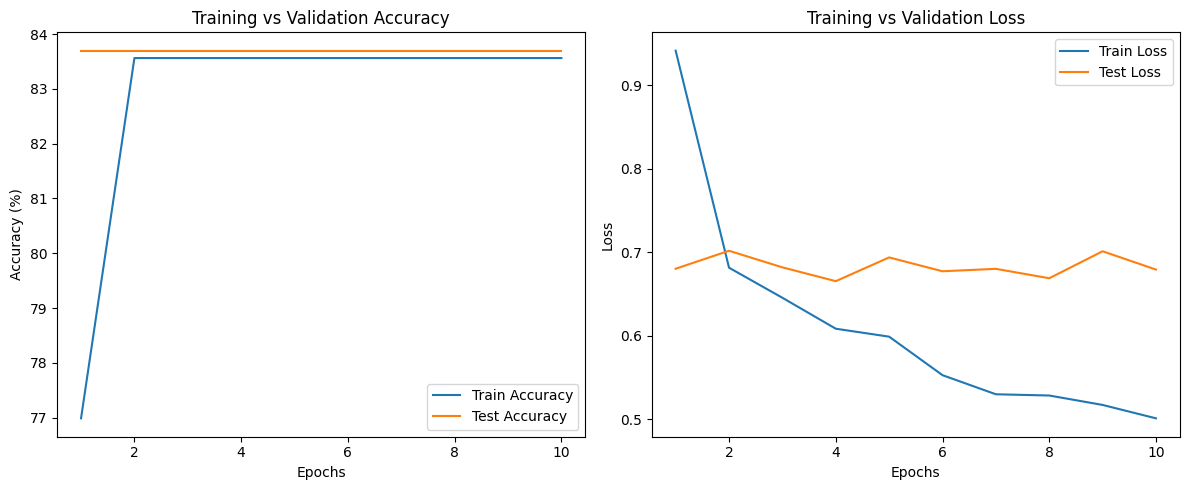

In [5]:
source_path = 'C:/Users/Afreen khan/OneDrive/Desktop/Images Folder'
folder_names = ['hungry', 'belly_pain', 'burping', 'discomfort', 'tired']
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        # Load image using OpenCV
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Load in RGB
        image = cv2.resize(image, (224, 224))  # Resize to 224x224 for ResNet input
        if self.transform:
            image = self.transform(image)
        return image, label
# Image transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert from numpy array to PIL image
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
])
# Load images from folders
def load_images_from_folders(source_path, folder_names):
    image_paths = []
    labels = []
    for label, folder_name in enumerate(folder_names):
        folder_path = os.path.join(source_path, folder_name)
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                image_paths.append(os.path.join(folder_path, filename))
                labels.append(label)  # Assign numerical label
    return image_paths, labels
image_paths, labels = load_images_from_folders(source_path, folder_names)
# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(image_paths, labels, train_size=0.8, stratify=labels)
# Create custom datasets
train_dataset = ImageDataset(X_train, Y_train, transform=transform)
test_dataset = ImageDataset(X_test, Y_test, transform=transform)
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Load pre-trained ResNet-50 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True).to(device)
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(folder_names)
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Training loop
num_epochs = 10
best_accuracy = 0.0
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass and optimization
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    # Calculate and store training loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    # Validate after each epoch
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Calculate and store validation loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    # Save model if it performs better on the test set
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
# Final evaluation after training
print(f"Best Test Accuracy: {best_accuracy:.2f}%")
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()